In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import tensorflow as tf
import tensorflow.keras.backend as K
import glob
import random
import os
# from DataLoader import Loader, configure_for_performance

In [25]:
class Loader(object):
    def __init__(self, root, shuffle=True):
        self.root = root
        A_folders = glob.glob(f'{root}/live/*')
        B_folders = glob.glob(f'{root}/live/*')

        def shuffle_list(A, B):
            random.shuffle(A)
            for i in range(len(A)):
                if A[i] == B[i]:
                    shuffle_list(A, B)
            return A

        A_imgs = []
        B_imgs = []
        for i in range(len(A_folders)):
            A = glob.glob(f'{A_folders[i]}/*.png')
            B = glob.glob(f'{B_folders[i]}/*.png')

            if shuffle:
                A = shuffle_list(A, B)
            A_imgs = A_imgs + A
            B_imgs = B_imgs + B
            
        self.A_imgs = np.array(A_imgs)

#         self.A_ds = tf.data.Dataset.from_tensor_slices(A_imgs)
#         self.B_ds = tf.data.Dataset.from_tensor_slices(B_imgs)


    def decode_img(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, 3)
        img = tf.image.resize(img, [56, 56])
        img = (img - 127.5) / 127.5

        return img

    def load(self):
        A_ds = tf.data.Dataset.from_tensor_slices(self.A_imgs)
        A_ds = A_ds.map(self.decode_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#         B_ds = self.B_ds.map(self.decode_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = tf.data.Dataset.zip((A_ds))

        return ds


def configure_for_performance(ds, cnt, batchz, shuffle=False):
    if shuffle==True:
        ds = ds.shuffle(buffer_size=cnt)
        ds = ds.batch(batchz)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    elif shuffle==False:
        ds = ds.batch(batchz)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [26]:
random_input = tf.keras.layers.Input(shape=100)

x = tf.keras.layers.Dense(64 * 7 * 7)(random_input)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Reshape((7, 7, 64))(x)

x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(2,2), padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(2,2), padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(2,2), padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5), padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), padding='same')(x)
generated_image = tf.keras.layers.Activation('tanh')(x)

generator = tf.keras.models.Model(inputs=random_input, outputs=generated_image)
generator.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              316736    
_________________________________________________________________
activation_14 (Activation)   (None, 3136)              0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 3136)              12544     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 128)       204928    
_________________________________________________________________
activation_15 (Activation)   (None, 14, 14, 128)       0   

In [27]:
image_input = tf.keras.layers.Input(shape=(56, 56, 3))

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=2, padding='same')(image_input)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=2, padding='same')(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=2, padding='same')(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), padding='same')(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5))(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3))(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(1)(x)
real_vs_fake_output = tf.keras.layers.Activation('sigmoid')(x)

discriminator = tf.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 128)       9728      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 128)         2049

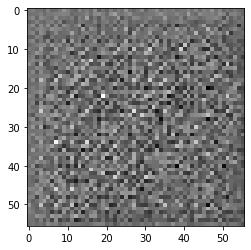

In [28]:
# generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [29]:
# discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49997735]], shape=(1, 1), dtype=float32)


In [30]:
disc_optim = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
gen_optim = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [31]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [32]:
# def rel_disc_loss(disc_r, disc_f):
#     epsilon=0.000001
#     return -(K.mean(K.log(K.sigmoid(disc_r - K.mean(disc_f, axis=0))+epsilon), axis=0)
#              +K.mean(K.log(1-K.sigmoid(disc_f - K.mean(disc_r, axis=0))+epsilon), axis=0))

# def rel_gen_loss(disc_r, disc_f):
#     epsilon=0.000001
#     return -(K.mean(K.log(K.sigmoid(disc_f - K.mean(disc_r, axis=0))+epsilon), axis=0)
#              +K.mean(K.log(1-K.sigmoid(disc_r - K.mean(disc_f, axis=0))+epsilon), axis=0))

In [33]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [34]:
root = 'E:/Iris_dataset/nd_labeling_iris_data/Cycle_PNG/1-fold/A'
ds = Loader(root, shuffle=True).load()

print(ds)

<ZipDataset shapes: (56, 56, 3), types: tf.float32>


In [35]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(gen_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optim.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optim.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_images

In [36]:
checkpoint_dir = 'E:/backup/ckp/GAN/rasgan/1/ckp'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optim,
                                 discriminator_optimizer=disc_optim,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
#     plt.show()

In [37]:
epochs = 300
batch_size = 2
cnt = 4554
noise_size = 100

for epoch in range(epochs):
    ds_shuffle = configure_for_performance(ds, cnt, batch_size)
    ds_it = iter(ds_shuffle)
    print(f'---------------now epoch : {epoch}---------------')
    for step in range(cnt//batch_size):
        img = next(ds_it)
        
        gen_img = train_step(img)
        
        if step % 100 == 0:
            img = np.array(gen_img[0])
            img = img * 127.5 + 127.5
            cv2.imwrite(f'E:/backup/ckp/GAN/rasgan/1/sample/generate_img_{epoch}_{step}.png', img)
            
        if step % 1000 == 0:
            print(f'---------------now step: {cnt//2}/{step}---------------')
    
    checkpoint.save(file_prefix = checkpoint_prefix)

---------------now epoch : 0---------------
---------------now step: 2277/0---------------
---------------now step: 2277/1000---------------
---------------now step: 2277/2000---------------
---------------now epoch : 1---------------
---------------now step: 2277/0---------------
---------------now step: 2277/1000---------------
---------------now step: 2277/2000---------------
---------------now epoch : 2---------------
---------------now step: 2277/0---------------
---------------now step: 2277/1000---------------
---------------now step: 2277/2000---------------
---------------now epoch : 3---------------
---------------now step: 2277/0---------------
---------------now step: 2277/1000---------------
---------------now step: 2277/2000---------------
---------------now epoch : 4---------------
---------------now step: 2277/0---------------
---------------now step: 2277/1000---------------
---------------now step: 2277/2000---------------
---------------now epoch : 5---------------
-

KeyboardInterrupt: 